## Product Classification Challenge 
#### Key Objectives 
- Analyze product descriptions and visual data to identify distinctive patterns.
- Develop models that effectively combine textual and image data for classification.
- Ensure the accuracy score exceeds 0.92. 
#### Evaluation
- Submissions are evaluated on accuracy between the predicted probability and the observed target.

Import essentials library

In [2]:
import sklearn as sk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import layers

#### Data Exploration
Most of the url_thumbnail is invalid, so just consider it as a text feature

In [3]:
# Data Loading and Exploration
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

print(len(test_df))

print(train_df.head())
train_df.info()


print(train_df['label'].unique())
print(train_df['label'].value_counts())
print(train_df.isnull().sum()) # there are 14 null values in the 'url-thumbnail' column

4998
   ID                                       product_name  \
0   0                               bút bi nước - bi tẩy   
1   1  Combo Theo Số lượng Ngòi Bút Mực Nước Gel Học ...   
2   2  Combo 30 ngòi bút bi nước chữ A 3 màu Xanh/Đỏ/Đen   
3   3  Bút Mực Gel Ngòi 0.5mm Kiểu Dáng Hoạt Hình Nhậ...   
4   4                                Bút nam châm hút bi   

                                       url_thumbnail  \
0  https://cf.shopee.vn/file/26a58c53bd57bb448cb7...   
1  https://salt.tikicdn.com/cache/280x280/ts/prod...   
2  https://cf.shopee.vn/file/58d9e4d45acc208bad5c...   
3  https://cf.shopee.vn/file/bbd4c7d2dd879e188410...   
4  https://p16-oec-va.ibyteimg.com/tos-maliva-i-o...   

                                                 url   label  
0    https://shopee.vn/product/142352325/21629377640  Bút bi  
1  https://tiki.vn/sp-p107615574.html?spid=107615604  Bút bi  
2    https://shopee.vn/product/174672045/14664208306  Bút bi  
3     https://shopee.vn/product/438496023/719

#### Preprocess Data and Model Training

In [5]:
# import libraries
from underthesea import word_tokenize, text_normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score

In [6]:
def clean_url_features(url):
    """Extract useful info from URLs, remove noise"""
    import re
    
    if pd.isna(url) or url == '' or not isinstance(url, str):
        return ''

    # domain
    domain = re.search(r'https?://(?:www\.)?([^/]+)', url)
    domain = domain.group(1) if domain else ''
    
    # useful parts, remove noisy IDs
    useful_parts = []
    
    # domain
    useful_parts.append(domain.replace('.', '_'))
    
    # category-like paths
    path_parts = url.split('/')
    for part in path_parts:
        # meaningful parts
        if (len(part) > 2 and 
            not part.isdigit() and 
            not re.match(r'^[0-9-]+$', part) and
            part not in ['https:', 'http:', 'www', 'product', 'sp-p']):
            useful_parts.append(part)
    
    return ' '.join(useful_parts)

In [7]:
# data engineering 
def data_engineering(df):
    df = df.copy()

    df['has_te_bao_explicit'] = df['product_name'].str.contains('tế bào', case=False).astype(int)
    df['has_cell_english'] = df['product_name'].str.contains('cell', case=False).astype(int)
    
    df['body_indicators'] = df['product_name'].str.contains('body|cơ thể|toàn thân|da|da chết', case=False).astype(int)
    df['face_indicators'] = df['product_name'].str.contains('face|mặt|facial', case=False).astype(int)

    df['platform_shopee'] = df['url'].str.contains('shopee', case=False).astype(int)
    df['platform_tiki'] = df['url'].str.contains('tiki', case=False).astype(int)
    df['platform_lazada'] = df['url'].str.contains('lazada', case=False).astype(int)

    return df

In [8]:
# data splitting

# train set
train_df = data_engineering(train_df)
y = train_df['label']
train_df['url_cleaned'] = train_df['url'].apply(clean_url_features)
train_df['url_thumbnail_cleaned'] = train_df['url_thumbnail'].apply(clean_url_features)

print("=== TẨY DA CHẾT samples ===")
tay_da_chet = train_df[train_df['label'] == 'Tẩy da chết']
print(f"Count: {len(tay_da_chet)}")
for i, (idx, row) in enumerate(tay_da_chet.head(10).iterrows()):
    print(f"{i+1}. {row['product_name']}")

print("\n=== TẨY TẾ BÀO CHẾT samples ===")
tay_te_bao_chet = train_df[train_df['label'] == 'Tẩy tế bào chết']
print(f"Count: {len(tay_te_bao_chet)}")
for i, (idx, row) in enumerate(tay_te_bao_chet.head(10).iterrows()):
    print(f"{i+1}. {row['product_name']}")

X = (train_df['product_name'].astype(str) + ' ' + 
     train_df['url_cleaned'].astype(str) + ' ' + 
     train_df['url_thumbnail_cleaned'].astype(str) + ' ' +
     # engineered features
     train_df.apply(lambda x: 'HAS_TE_BAO ' if x['has_te_bao_explicit'] else '', axis=1) +
     train_df.apply(lambda x: 'BODY_TYPE ' if x['body_indicators'] else '', axis=1) +
     train_df.apply(lambda x: 'FACE_TYPE ' if x['face_indicators'] else '', axis=1) +
     train_df.apply(lambda x: 'SHOPEE_PLATFORM ' if x['platform_shopee'] else '', axis=1) +
     train_df.apply(lambda x: 'TIKI_PLATFORM ' if x['platform_tiki'] else '', axis=1)
    ).values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# test set
test_df = data_engineering(test_df)


=== TẨY DA CHẾT samples ===
Count: 797
1. Dũa Tay Và Chân, Tẩy Tế Bào Chết, Bảng Chà, Loại Bỏ Da Chết, Loại Bỏ Vết Chai
2. CANOVA ACNELL 50+ 50mL Kem ngừa mụn ban NGÀY, chống tia UV, loại tế bào chết, dưỡng da
3. Cọ Rửa Mặt, Mút Rửa Mặt Bạch Tuộc Skincare Cọ Rửa Mặt Tẩy Tế Bào Chết Đáng Yêu  Phong Cách Hàn Quốc 1643 
4. Tinh chất tẩy da chết, se lỗ chân lông The Ordinary Salicylic Acid 2% Anhydrous Solution 30ml
5. Gel rửa mặt không có xà phòng, làm sạch và loại bỏ tế bào da chết SVR SEBIACLEAR GEL MOUSSANT 400ml
6. Tẩy Tế Bào Chết Dịu Nhẹ Cho Da Nhạy Cảm Cosrx Low pH Good Night Soft Peeling Gel
7. Tẩy Tế Bào Chết Ho [ combo 30 Gói =30ml ]
8. KEM TẨY DA CHẾT COFFEE
9. Dung dịch tẩy da chết và thu nhỏ lỗ chân lông Paula's Choice Resist Daily Pore Refining Treatment 2% BHA 30ml mã 7827
10. Bột Cám Gạo Cafe 100gr Đắp Mặt, Tắm Trắng, Tẩy Tế Bào Chết

=== TẨY TẾ BÀO CHẾT samples ===
Count: 760
1. Tẩy Da Chết Fraijour Original Herb Wormwood Peeling Gel 150ml
2. Tẩy tế bào chết thảo mộc Mario

In [9]:
# tokenization
import string

punctuations = set(string.punctuation)
def vn_tokenizer(text):
    normalized_text = text_normalize(text)
    underthesea_tokens = word_tokenize(normalized_text, format='text').split()
    underthesea_punctuations_filtered = [token for token in underthesea_tokens if token not in punctuations]
    return underthesea_punctuations_filtered

label_encoder = LabelEncoder()

# encode target 
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [ ]:
from transformers import AutoTokenizer

# PhoBERT tokenizer
phobert_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

def phobert_tokenize(text):
    # Simple tokenization with PhoBERT
    tokens = phobert_tokenizer.tokenize(text)
    # tokens -> string 
    text = ' '.join(tokens)
    return text

In [11]:
tfidf = TfidfVectorizer(
        tokenizer=vn_tokenizer, 
        max_features=7000, 
        ngram_range=(1, 2), 
        min_df=5,
        max_df=0.9,
        sublinear_tf=True,
        use_idf=True,
        smooth_idf=True,
        norm='l2'
    )

In [12]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

# XGBoost model
robust_xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    learning_rate=0.01,
    max_depth=10,
    n_estimators=1000,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    tree_method='hist'
)

# Train and evaluate
robust_xgb.fit(X_train_tfidf, y_train_encoded)

train_preds = robust_xgb.predict(X_train_tfidf)
val_preds = robust_xgb.predict(X_val_tfidf)

train_accuracy = accuracy_score(y_train_encoded, train_preds)
val_accuracy = accuracy_score(y_val_encoded, val_preds)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# validation accuracy: 0.9202
# train accuracy: 1.0000

d:\_code\deep-learning-notebooks\venv-clean\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\_code\deep-learning-notebooks\venv-clean\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:42:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train Accuracy: 0.9977
Validation Accuracy: 0.9062


The performance of XGBoost (also Random Forest Cls) is not really good, so I decide to try a simple Neural Network

In [ ]:
# keras model 
from scikeras.wrappers import KerasClassifier

 
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
input_dim = X_train_tfidf.shape[1]

# build model
def build_model(num_classes, input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),

        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.6),              
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),              
        
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),              
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Use GPU-optimized optimizer
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

d:\_code\deep-learning-notebooks\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [71]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=8,
        min_lr=1e-6,
        mode='max',
        verbose=1
    )
]

In [78]:

# Wrap Keras model
keras_clf = KerasClassifier(
    model=build_model, 
    model__input_dim=input_dim,
    model__num_classes=len(label_encoder.classes_),
    epochs=100,                  # More epochs with early stopping
    batch_size=128,              # Larger batch size
    validation_split=0.2,        # Add validation
    callbacks=callbacks,
    verbose=1
)

pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clf', keras_clf)
])

pipeline.fit(X_train, y_train_encoded)
train_accuracy = accuracy_score(y_train_encoded, pipeline.predict(X_train))

y_val_pred = pipeline.predict(X_val)
val_accuracy = accuracy_score(y_val_encoded, y_val_pred)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4067 - loss: 2.2228 - val_accuracy: 0.2157 - val_loss: 2.7713 - learning_rate: 0.0010
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7809 - loss: 0.7232 - val_accuracy: 0.4593 - val_loss: 2.0003 - learning_rate: 0.0010
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8405 - loss: 0.5001 - val_accuracy: 0.8517 - val_loss: 0.9067 - learning_rate: 0.0010
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8722 - loss: 0.3784 - val_accuracy: 0.8868 - val_loss: 0.3870 - learning_rate: 0.0010
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8865 - loss: 0.3262 - val_accuracy: 0.8988 - val_loss: 0.2710 - learning_rate: 0.0010
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8955 - loss: 0.2975 - val_accuracy: 0.9052 - val_loss: 0.2539 - learning_rate: 0.0010
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9019 - loss: 0.

In [ ]:

print("Training fast ensemble...")


fast_xgb = XGBClassifier(
    n_estimators=500,         
    learning_rate=0.02,        
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1,
    verbosity=2
)


X_train_tfidf = tfidf.transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

print("Training XGBoost...")
fast_xgb.fit(X_train_tfidf, y_train_encoded)

# Quick ensemble
nn_val_pred = pipeline.predict(X_val)
xgb_val_pred = fast_xgb.predict(X_val_tfidf)

def combine_predictions(nn_pred, xgb_pred, nn_weight=0.6):
    combined = []
    for i in range(len(nn_pred)):
        if nn_pred[i] == xgb_pred[i]:
            combined.append(nn_pred[i])  
        else:
            combined.append(nn_pred[i] if np.random.random() < nn_weight else xgb_pred[i])
    return np.array(combined)

ensemble_pred = combine_predictions(nn_val_pred, xgb_val_pred)
ensemble_acc = accuracy_score(y_val_encoded, ensemble_pred)

print(f"NN Accuracy: {accuracy_score(y_val_encoded, nn_val_pred):.4f}")
print(f"XGBoost Accuracy: {accuracy_score(y_val_encoded, xgb_val_pred):.4f}")
print(f"Ensemble Accuracy: {ensemble_acc:.4f}")

#  NN Accuracy: 0.9122
#  XGBoost Accuracy: 0.9192 (Choose XGBoost)
#  Ensemble Accuracy: 0.9132

Training fast ensemble...
Training XGBoost...
[20:49:29] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (17936, 1995, 2492520).
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
NN Accuracy: 0.9122
XGBoost Accuracy: 0.9192
Ensemble Accuracy: 0.9132


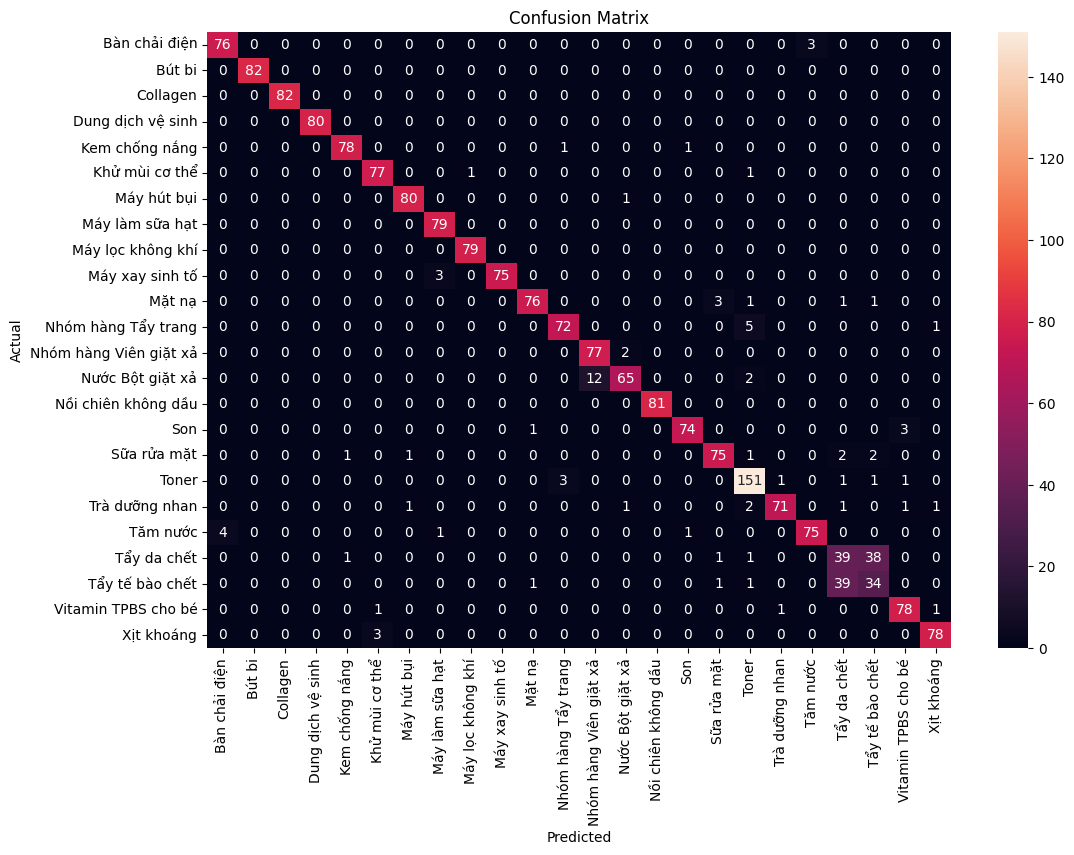

In [93]:
# analyze data a bit
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val_encoded, val_preds)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Predict the test set

In [ ]:
print(len(test_df))
test_df['url_cleaned'] = test_df['url'].apply(clean_url_features)
test_df['url_thumbnail_cleaned'] = test_df['url_thumbnail'].apply(clean_url_features)

x_test = (test_df['product_name'].astype(str) + ' ' + 
          test_df['url_cleaned'].astype(str) + ' ' + 
          test_df['url_thumbnail_cleaned'].astype(str) + ' ' +
          
          test_df.apply(lambda x: 'HAS_TE_BAO ' if x['has_te_bao_explicit'] else '', axis=1) +
          test_df.apply(lambda x: 'BODY_TYPE ' if x['body_indicators'] else '', axis=1) +
          test_df.apply(lambda x: 'FACE_TYPE ' if x['face_indicators'] else '', axis=1) +
          test_df.apply(lambda x: 'SHOPEE_PLATFORM ' if x['platform_shopee'] else '', axis=1) +
          test_df.apply(lambda x: 'TIKI_PLATFORM ' if x['platform_tiki'] else '', axis=1)
         ).to_numpy()

x_test_features = tfidf.transform(x_test)
y_pred = robust_xgb.predict(x_test_features)
predicted_labels = label_encoder.inverse_transform(y_pred)

# Compare product name with predicted label
test_df['predicted_label'] = predicted_labels

print(test_df[['product_name', 'predicted_label']].head(100))

4998
                                         product_name      predicted_label
0   Mặt nạ mắt BIOAQUA 60 miếng Mặt nạ mắt giảm th...               Mặt nạ
1   Tẩy trang Dr Lacir Start36 sữa tẩy trang dịu n...  Nhóm hàng Tẩy trang
2   Xịt khóa make up dưỡng ẩm trong suốt nhũ lấp l...           Xịt khoáng
3   Mặt Nạ Tinh Chất Anti Wrinkle Chống Nhăn Hàn Quốc               Mặt nạ
4   Bông Tẩy Da Chết Frudia Green Grape Pore Peeli...      Tẩy tế bào chết
..                                                ...                  ...
95  [CHÍNH HÃNG] 10 Gói Men Vi Sinh Cho Bé LACTO-F...  Vitamin TPBS cho bé
96  Nước Hoa Hồng Giảm Mụn Some By Mi AHA BHA PHA ...                Toner
97  Máy làm sữa hạt đa năng SEKA, máy xay nấu đa n...      Máy làm sữa hạt
98                                 Sữa rửa mặt Cerave          Sữa rửa mặt
99  Dock Sạc mini / Đế Sạc Treo Tường Cho Máy Hút ...          Máy hút bụi

[100 rows x 2 columns]


In [92]:
# return model prediction
output_df = pd.DataFrame(range(len(test_df)), columns=['ID'])
output_df['label'] = predicted_labels

output_df.to_csv("data/output.csv", index=False, encoding='utf-8-sig')